In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=23f38efc4a8e4385f11161ff98402629d16934c049c2524f3005cffd6b4f9943
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,sum,avg,count,max,min,when

In [3]:
spark=SparkSession.builder.appName('Traffic analysis').getOrCreate()

In [4]:
df=spark.read.csv('/content/Metro_Interstate_Traffic_Volume.csv',
                        header=True,inferSchema=True)
df.show(10)

+--------------+-------+------+-------+-------+----------+------------+-------------------+----------------+
|traffic_volume|holiday|  temp|rain_1h|snow_1h|clouds_all|weather_main|weather_description|       date_time|
+--------------+-------+------+-------+-------+----------+------------+-------------------+----------------+
|          5545|   None|288.28|    0.0|    0.0|        40|      Clouds|   scattered clouds|02-10-2012 09:00|
|          4516|   None|289.36|    0.0|    0.0|        75|      Clouds|      broken clouds|02-10-2012 10:00|
|          4767|   None|289.58|    0.0|    0.0|        90|      Clouds|    overcast clouds|02-10-2012 11:00|
|          5026|   None|290.13|    0.0|    0.0|        90|      Clouds|    overcast clouds|02-10-2012 12:00|
|          4918|   None|291.14|    0.0|    0.0|        75|      Clouds|      broken clouds|02-10-2012 13:00|
|          5181|   None|291.72|    0.0|    0.0|         1|       Clear|       sky is clear|02-10-2012 14:00|
|          5584|   

In [5]:
df.dtypes

[('traffic_volume', 'int'),
 ('holiday', 'string'),
 ('temp', 'double'),
 ('rain_1h', 'double'),
 ('snow_1h', 'double'),
 ('clouds_all', 'int'),
 ('weather_main', 'string'),
 ('weather_description', 'string'),
 ('date_time', 'string')]

In [6]:
df.printSchema()

root
 |-- traffic_volume: integer (nullable = true)
 |-- holiday: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- date_time: string (nullable = true)



In [7]:
df.describe().show()

+-------+------------------+--------------------+------------------+-------------------+--------------------+-----------------+------------+-------------------+----------------+
|summary|    traffic_volume|             holiday|              temp|            rain_1h|             snow_1h|       clouds_all|weather_main|weather_description|       date_time|
+-------+------------------+--------------------+------------------+-------------------+--------------------+-----------------+------------+-------------------+----------------+
|  count|             48204|               48204|             48204|              48204|               48204|            48204|       48204|              48204|           48204|
|   mean|3259.8183553232097|                NULL| 281.2058703012135|0.33426396149697535|2.223881835532321...|49.36223135009543|        NULL|               NULL|            NULL|
| stddev|1986.8606704463612|                NULL|13.338231912676308|  44.78913303693933|0.008167611205361601|3

# **Checking for Null Values**

In [8]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+--------------+-------+----+-------+-------+----------+------------+-------------------+---------+
|traffic_volume|holiday|temp|rain_1h|snow_1h|clouds_all|weather_main|weather_description|date_time|
+--------------+-------+----+-------+-------+----------+------------+-------------------+---------+
|             0|      0|   0|      0|      0|         0|           0|                  0|        0|
+--------------+-------+----+-------+-------+----------+------------+-------------------+---------+



**Univariate Analysis**

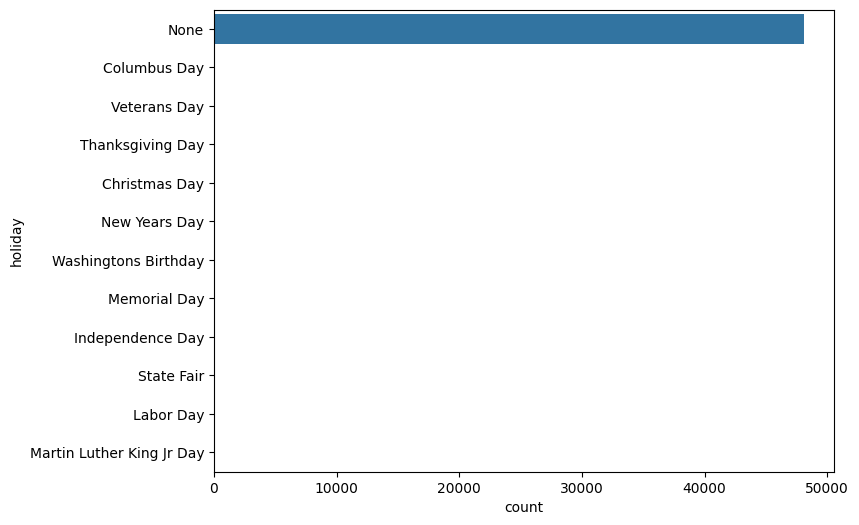

In [9]:
#Plotting frequency of each category in holiday column
plt.figure(figsize = (8,6))
sns.countplot(y='holiday', data = df.toPandas())
plt.show()

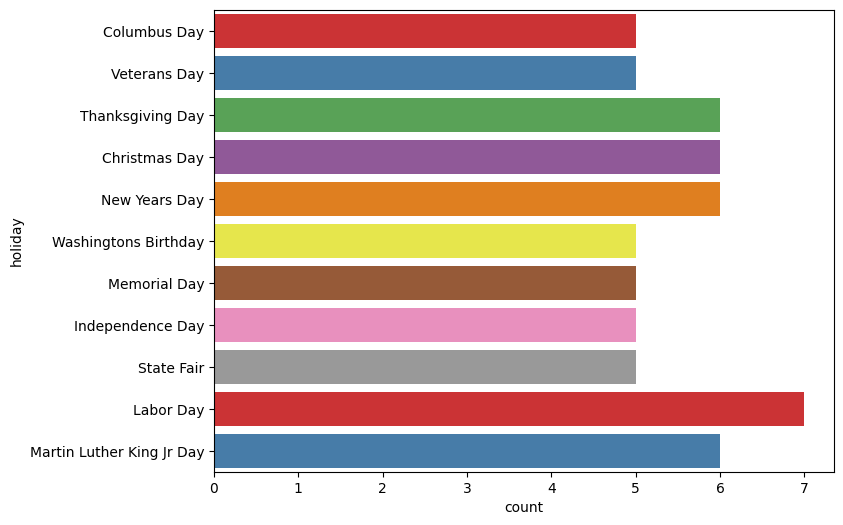

In [10]:
#'None' is far greater than the other days. Removing None data to visualize the others
holidays = df.toPandas().loc[df.toPandas().holiday != 'None']
plt.figure(figsize=(8,6))
sns.countplot(y='holiday', data= holidays, palette='Set1',hue='holiday')
plt.show()

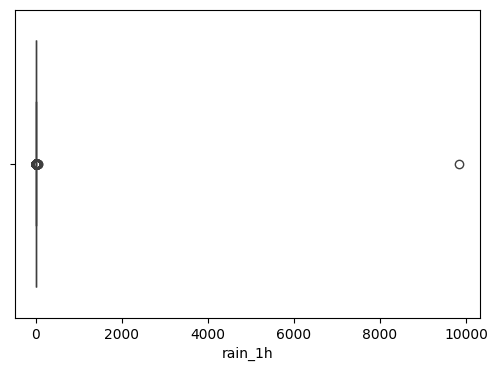

In [11]:
#plotting distribution of rain_1h variable
plt.figure(figsize=(6,4))
sns.boxplot(x='rain_1h', data = df.toPandas())
plt.show()

**There is one data point recording almost 10000mm of rainfall in 1 hour. Clearly this is an error and should be removed in the data cleaning part**

# **Converting the temp column from Kelvin to Celsius**

In [12]:
df = df.withColumn('temp', col('temp') - 273.15)
df.show()

+--------------+-------+------------------+-------+-------+----------+------------+-------------------+----------------+
|traffic_volume|holiday|              temp|rain_1h|snow_1h|clouds_all|weather_main|weather_description|       date_time|
+--------------+-------+------------------+-------+-------+----------+------------+-------------------+----------------+
|          5545|   None|15.129999999999995|    0.0|    0.0|        40|      Clouds|   scattered clouds|02-10-2012 09:00|
|          4516|   None|16.210000000000036|    0.0|    0.0|        75|      Clouds|      broken clouds|02-10-2012 10:00|
|          4767|   None|16.430000000000007|    0.0|    0.0|        90|      Clouds|    overcast clouds|02-10-2012 11:00|
|          5026|   None|16.980000000000018|    0.0|    0.0|        90|      Clouds|    overcast clouds|02-10-2012 12:00|
|          4918|   None| 17.99000000000001|    0.0|    0.0|        75|      Clouds|      broken clouds|02-10-2012 13:00|
|          5181|   None| 18.5700

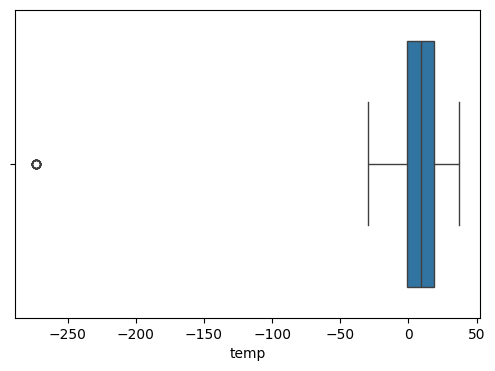

In [13]:
#plotting distribution of temperature variable
plt.figure(figsize=(6,4))
sns.boxplot(x='temp', data = df.toPandas())
plt.show()

**There are some Data point which are less than -250 degree celsius. This is clearly an error in recording and shall be cleaned in the cleaning phase**

**Bi-variate Analysis**

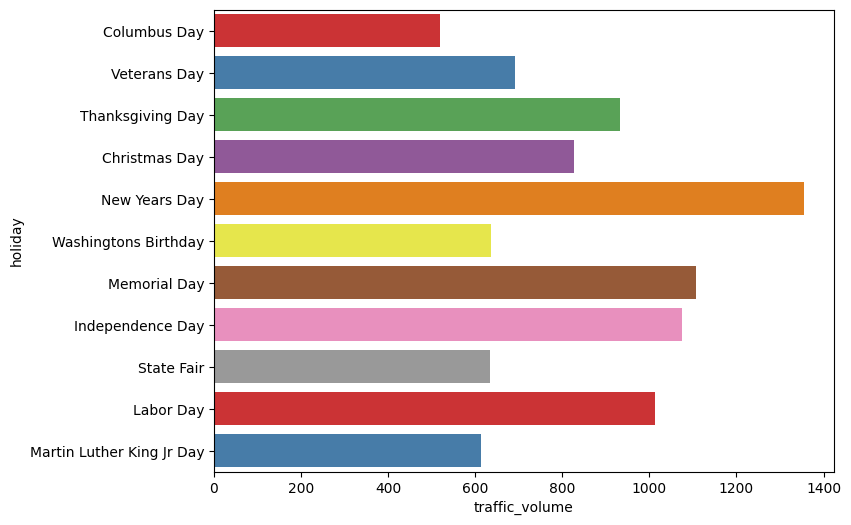

In [14]:
#Exploring traffic volume on holidays
plt.figure(figsize=(8,6))
sns.barplot(y='holiday',x='traffic_volume', data = holidays,palette='Set1',hue='holiday',errorbar=None)
plt.show()

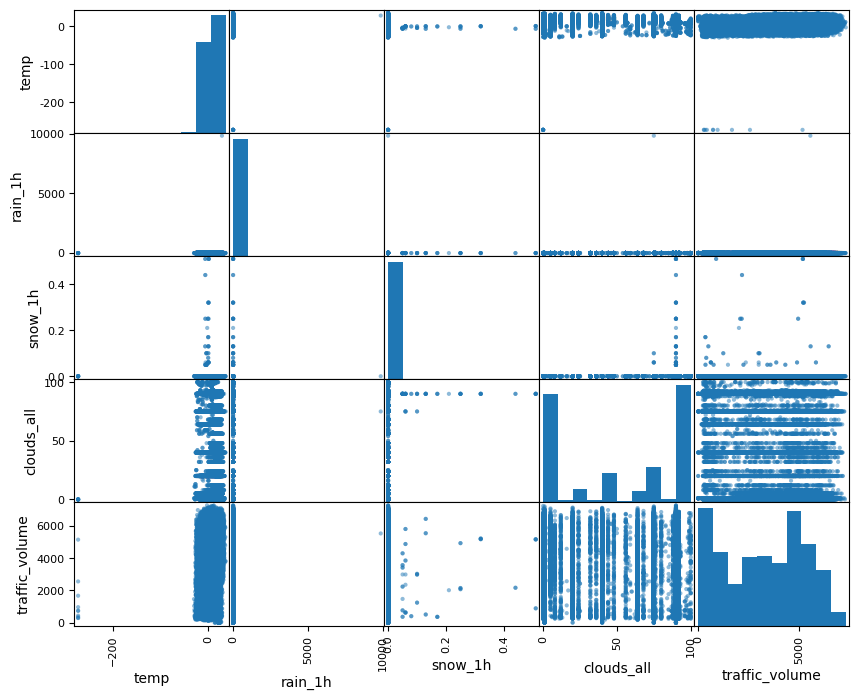

In [15]:
#Plotting relationship between temp, rain_1h, snow_1h, cloud_all.
num_vars = ['temp','rain_1h','snow_1h','clouds_all','traffic_volume']
from pandas.plotting import scatter_matrix
scatter_matrix(df.toPandas()[num_vars],figsize=(10,8))
plt.show()

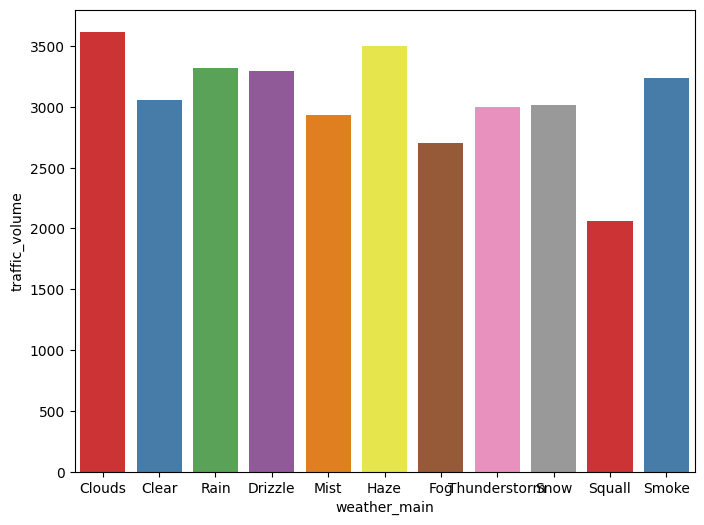

In [16]:
#Plotting weather_main over traffic volume
plt.figure(figsize=(8,6))
sns.barplot(x='weather_main', y = 'traffic_volume', data = df.toPandas(),palette='Set1',hue='weather_main',errorbar=None)
plt.show()

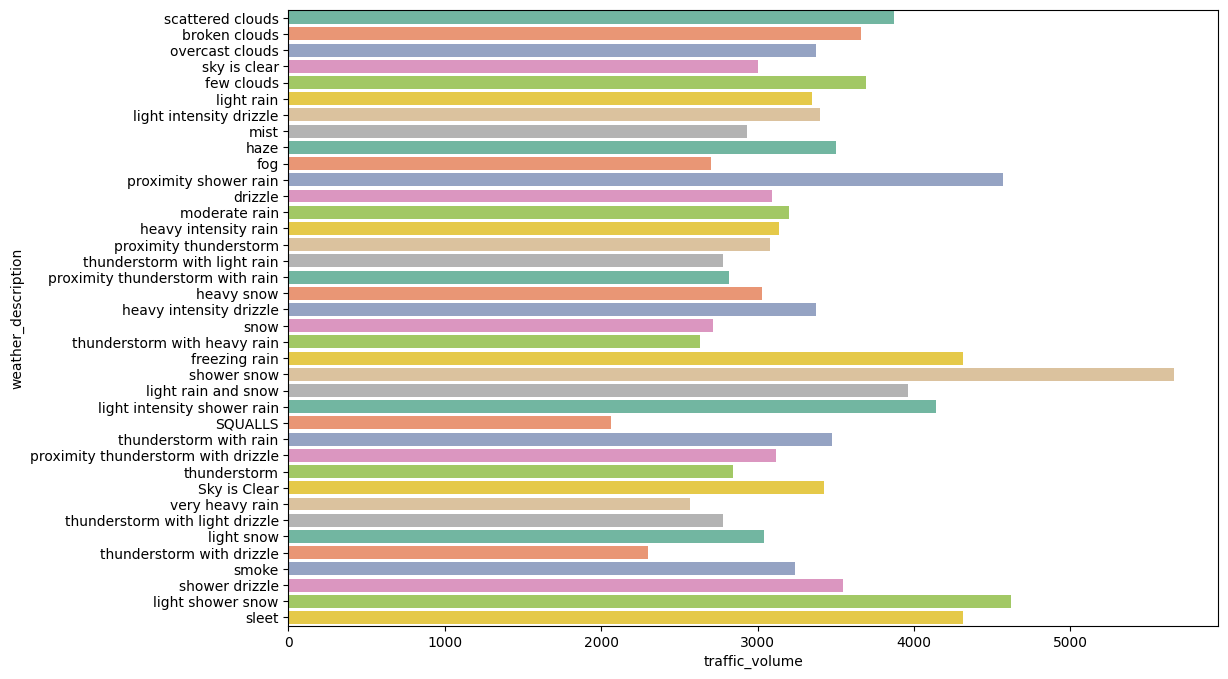

In [17]:
#Plotting weather_description over traffic volume
plt.figure(figsize=(12,8))
sns.barplot(y='weather_description', x = 'traffic_volume', data = df.toPandas(),palette='Set2',hue='weather_description',errorbar=None)
plt.show()

# **Cleaning our Data by removing outliers**

In [55]:
df.count()

48193

In [59]:
clean_df=df.filter(df.rain_1h<500)
clean_df=clean_df.filter(df.temp>-100)
clean_df.count()

48193

# **Running Queries on our data**

In [60]:
#creating temp view of our DF
clean_df.createOrReplaceTempView('traffic_data')

In [61]:
spark.sql('''select * from traffic_data''').show()

+--------------+-------+------------------+-------+-------+----------+------------+-------------------+-------------------+----+---+-----+----+-----------+
|traffic_volume|holiday|              temp|rain_1h|snow_1h|clouds_all|weather_main|weather_description|          date_time|hour|day|month|year|day_of_week|
+--------------+-------+------------------+-------+-------+----------+------------+-------------------+-------------------+----+---+-----+----+-----------+
|          5545|   None|15.129999999999995|    0.0|    0.0|        40|      Clouds|   scattered clouds|2012-10-02 09:00:00|   9|  2|   10|2012|          3|
|          4516|   None|16.210000000000036|    0.0|    0.0|        75|      Clouds|      broken clouds|2012-10-02 10:00:00|  10|  2|   10|2012|          3|
|          4767|   None|16.430000000000007|    0.0|    0.0|        90|      Clouds|    overcast clouds|2012-10-02 11:00:00|  11|  2|   10|2012|          3|
|          5026|   None|16.980000000000018|    0.0|    0.0|     

In [62]:
#finding out average traffic volume by weather main
spark.sql('''select
              weather_main as Main_Weather,
              avg(traffic_volume) as traffic
              from traffic_data
              group by weather_main
              order by avg(traffic_volume) desc''').show()

+------------+------------------+
|Main_Weather|           traffic|
+------------+------------------+
|      Clouds| 3618.449749406489|
|        Haze|3502.1014705882353|
|        Rain|3317.5145476988187|
|     Drizzle| 3290.727073036793|
|       Smoke|           3237.65|
|       Clear|3057.2074583364474|
|        Snow| 3016.844228094576|
|Thunderstorm|3001.6208897485494|
|        Mist| 2932.956638655462|
|         Fog| 2703.720394736842|
|      Squall|           2061.75|
+------------+------------------+



In [63]:
#finding out average traffic volume by weather description
spark.sql('''select
              weather_description as Weather_Description,
              avg(traffic_volume) as traffic
              from traffic_data
              group by weather_description
              order by avg(traffic_volume) desc''').show()

+--------------------+------------------+
| Weather_Description|           traffic|
+--------------------+------------------+
|         shower snow|            5664.0|
|   light shower snow| 4618.636363636364|
|proximity shower ...| 4567.845588235294|
|       freezing rain|            4314.0|
|               sleet| 4312.666666666667|
|light intensity s...| 4140.307692307692|
| light rain and snow|3961.1666666666665|
|    scattered clouds|3875.6223634787634|
|          few clouds|3691.4534764826176|
|       broken clouds|3661.1420917273895|
|      shower drizzle|3547.6666666666665|
|                haze|3502.1014705882353|
|thunderstorm with...|3476.4054054054054|
|        Sky is Clear| 3423.148899188876|
|light intensity d...|3400.5672727272727|
|     overcast clouds| 3375.963589844519|
|heavy intensity d...|       3371.109375|
|          light rain|3349.2571174377226|
|               smoke|           3237.65|
|       moderate rain| 3202.603966346154|
+--------------------+------------

In [64]:
spark.sql('''select
        case
          when clouds_all<25 then 'Below 25%'
          when clouds_all between 25 and 75 then 'between 50% and 75%'
          else 'Above 75%'
        end as Cloud_Percentage,
    avg(traffic_volume) as Average_Traffic
    from traffic_data
    group by Cloud_Percentage
    order by Average_Traffic desc''').show()

+-------------------+------------------+
|   Cloud_Percentage|   Average_Traffic|
+-------------------+------------------+
|between 50% and 75%| 3567.822565503115|
|          Above 75%|3276.7368187614347|
|          Below 25%|3048.4781170345464|
+-------------------+------------------+



**Rates of Rainfall**

light rainfall: Less than 2 mm per hour.

Moderate rainfall: Greater than 2 mm, but less than 10 mm per hour.

Heavy rainfall: Greater than 10 mm per hour, but less than 50 mm per hour.

Violent rainfall: Greater than 50 mm per hour.

In [65]:
spark.sql('''select
        case
          when rain_1h<2 then 'Light Rainfall'
          when rain_1h between 2 and 10 then 'Moderate Rainfall'
          when rain_1h between 10 and 50 then 'Heavy Rainfall'
          else 'Violent Rainfall'
        end as Rainfall_Level,
    avg(traffic_volume) as Average_Traffic
    from traffic_data
    group by Rainfall_Level
    order by Average_Traffic desc''').show()

+-----------------+------------------+
|   Rainfall_Level|   Average_Traffic|
+-----------------+------------------+
|   Light Rainfall|3263.7264847308925|
|Moderate Rainfall|3143.7324561403507|
|   Heavy Rainfall|            2327.0|
| Violent Rainfall|             315.0|
+-----------------+------------------+



In [88]:
spark.sql('''select
          case
            when temp<0 then 'Freezing'
            when temp between 0 and 20 then 'cold'
            when temp between 20 and 30 then 'warm'
            else 'hot'
          end as Temp_levels,
        avg(traffic_volume) as Average_Traffic
        from traffic_data
        group by Temp_levels
        order by Average_Traffic desc''').show()

+-----------+------------------+
|Temp_levels|   Average_Traffic|
+-----------+------------------+
|        hot|  4786.12935323383|
|       warm|3776.7650873339608|
|       cold|3197.3888955799107|
|   Freezing|2960.7485924480143|
+-----------+------------------+



In [66]:
holiday_traffic = clean_df.groupBy("holiday").agg(
    avg("traffic_volume").alias("avg_traffic_volume")
).orderBy("avg_traffic_volume", ascending=False)
holiday_traffic.show()


+--------------------+------------------+
|             holiday|avg_traffic_volume|
+--------------------+------------------+
|                None| 3263.208987783595|
|       New Years Day|            1356.0|
|        Memorial Day|            1107.6|
|    Independence Day|            1076.0|
|           Labor Day|1013.1428571428571|
|    Thanksgiving Day|             933.5|
|       Christmas Day|             827.5|
|        Veterans Day|             691.4|
|Washingtons Birthday|             635.2|
|          State Fair|             634.8|
|Martin Luther Kin...| 612.6666666666666|
|        Columbus Day|             519.4|
+--------------------+------------------+



In [38]:
from pyspark.sql.functions import hour, dayofmonth, month, year, dayofweek, unix_timestamp
clean_df = clean_df.withColumn('date_time', unix_timestamp(col('date_time'), 'dd-MM-yyyy HH:mm').cast('timestamp'))

In [39]:
# Extracting useful time components: hour, day, month, year, and day of the week
clean_df = clean_df.withColumn('hour', hour(col('date_time')))
clean_df = clean_df.withColumn('day', dayofmonth(col('date_time')))
clean_df = clean_df.withColumn('month', month(col('date_time')))
clean_df = clean_df.withColumn('year', year(col('date_time')))
clean_df = clean_df.withColumn('day_of_week', dayofweek(col('date_time')))  # 1 = Sunday, 7 = Saturday

In [40]:
clean_df.show(5)

+--------------+-------+------------------+-------+-------+----------+------------+-------------------+-------------------+----+---+-----+----+-----------+
|traffic_volume|holiday|              temp|rain_1h|snow_1h|clouds_all|weather_main|weather_description|          date_time|hour|day|month|year|day_of_week|
+--------------+-------+------------------+-------+-------+----------+------------+-------------------+-------------------+----+---+-----+----+-----------+
|          5545|   None|15.129999999999995|    0.0|    0.0|        40|      Clouds|   scattered clouds|2012-10-02 09:00:00|   9|  2|   10|2012|          3|
|          4516|   None|16.210000000000036|    0.0|    0.0|        75|      Clouds|      broken clouds|2012-10-02 10:00:00|  10|  2|   10|2012|          3|
|          4767|   None|16.430000000000007|    0.0|    0.0|        90|      Clouds|    overcast clouds|2012-10-02 11:00:00|  11|  2|   10|2012|          3|
|          5026|   None|16.980000000000018|    0.0|    0.0|     

In [46]:
# Group by day of the week (1 = Sunday, ..., 7 = Saturday) and calculate average traffic volume
df_dayofweek = df.groupBy('day_of_week').agg(avg('traffic_volume').alias('avg_traffic_volume')).orderBy('day_of_week')
df_dayofweek.show()

+-----------+------------------+
|day_of_week|avg_traffic_volume|
+-----------+------------------+
|          1|  2370.02024468395|
|          2|3309.0724084287936|
|          3| 3488.555799006719|
|          4| 3583.196681096681|
|          5|3637.8996626081853|
|          6| 3657.211211943794|
|          7|2773.6381203337723|
+-----------+------------------+



In [90]:
spark.sql('''select
          case
            when hour<4 then 'Late Night'
            when hour between 4 and 8 then 'Early Morning'
            when temp between 8 and 12 then 'Late Morning'
            when temp between 12 and 16 then 'Afternoon'
            when temp between 16 and 20 then 'Evening'
            else 'Early Night'
          end as Time_of_Day,
        avg(traffic_volume) as Average_Traffic
        from traffic_data
        group by Time_of_Day
        order by Average_Traffic desc''').show()

+-------------+------------------+
|  Time_of_Day|   Average_Traffic|
+-------------+------------------+
|    Afternoon|4060.6043193212495|
| Late Morning| 4022.733080927591|
|  Early Night|4012.4225920088998|
|      Evening| 3953.775714706749|
|Early Morning| 3254.010103926097|
|   Late Night| 528.2413877952756|
+-------------+------------------+



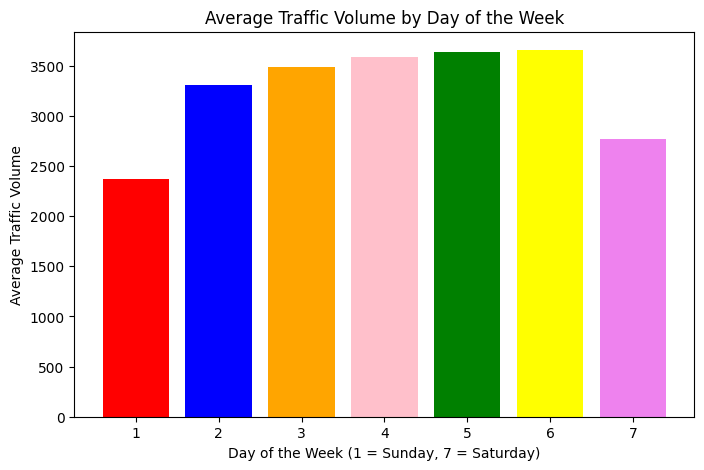

In [45]:
# Plottin average traffic volume by day of the week
plt.figure(figsize=(8, 5))
plt.bar(df_dayofweek.toPandas()['day_of_week'], df_dayofweek.toPandas()['avg_traffic_volume'],
        color=['red','blue','orange','pink','green','yellow','violet'])
plt.title('Average Traffic Volume by Day of the Week')
plt.xlabel('Day of the Week (1 = Sunday, 7 = Saturday)')
plt.ylabel('Average Traffic Volume')
plt.show()

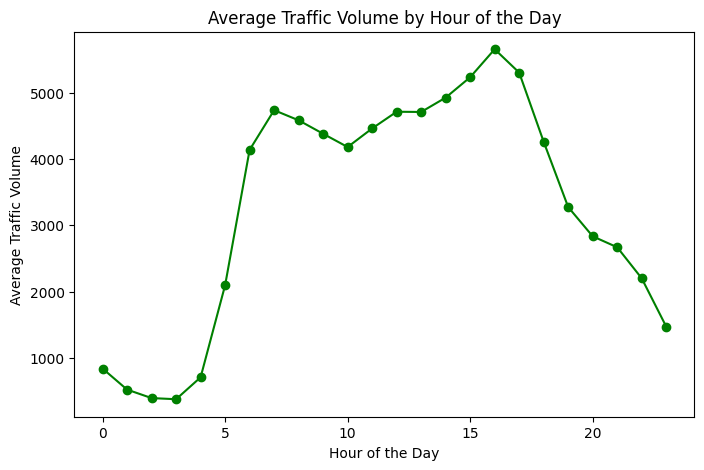

In [49]:
# Plotting average traffic volume by hour of the day
df_hourly = df.groupBy('hour').agg(avg('traffic_volume').alias('avg_traffic_volume')).orderBy('hour')
plt.figure(figsize=(8, 5))
plt.plot(df_hourly.toPandas()['hour'], df_hourly.toPandas()['avg_traffic_volume'], marker='o', color='green')
plt.title('Average Traffic Volume by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Traffic Volume')
plt.show()

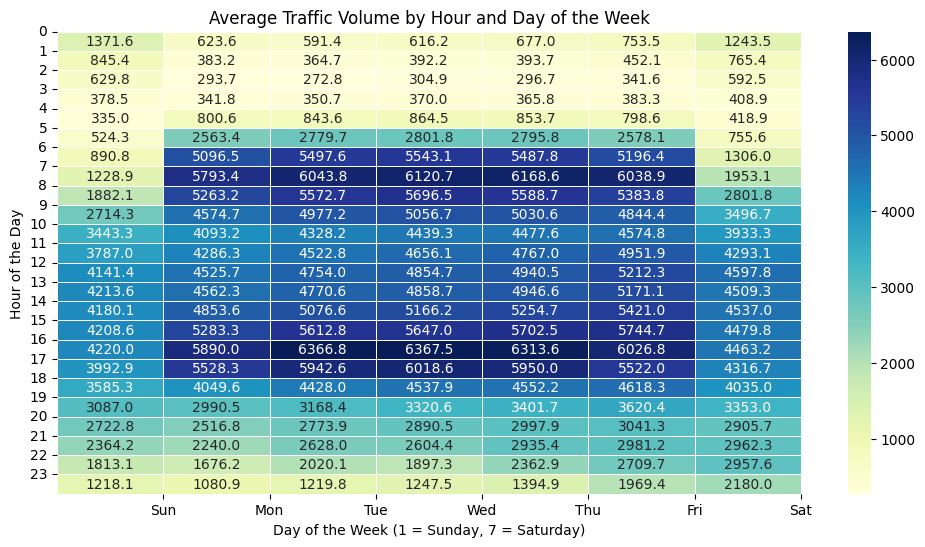

In [54]:
# Group by hour and day of the week, calculating average traffic volume
from pyspark.sql import functions as F
traffic_heatmap_data = df.groupBy("hour", "day_of_week").agg(F.avg("traffic_volume").alias("avg_traffic_volume")).orderBy("day_of_week", "hour")
plt.figure(figsize=(12, 6))
traffic_heatmap_data = traffic_heatmap_data.toPandas().pivot(index='hour', columns='day_of_week', values='avg_traffic_volume')
sns.heatmap(traffic_heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f", linewidths=.5)
plt.title('Average Traffic Volume by Hour and Day of the Week')
plt.xlabel('Day of the Week (1 = Sunday, 7 = Saturday)')
plt.ylabel('Hour of the Day')
plt.xticks(ticks=range(1, 8), labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])  # Rename x-axis labels
plt.yticks(ticks=range(0, 24), labels=range(24), rotation=0)  # Hour labels
plt.show()


In [91]:
clean_df.show()

+--------------+-------+------------------+-------+-------+----------+------------+-------------------+-------------------+----+---+-----+----+-----------+
|traffic_volume|holiday|              temp|rain_1h|snow_1h|clouds_all|weather_main|weather_description|          date_time|hour|day|month|year|day_of_week|
+--------------+-------+------------------+-------+-------+----------+------------+-------------------+-------------------+----+---+-----+----+-----------+
|          5545|   None|15.129999999999995|    0.0|    0.0|        40|      Clouds|   scattered clouds|2012-10-02 09:00:00|   9|  2|   10|2012|          3|
|          4516|   None|16.210000000000036|    0.0|    0.0|        75|      Clouds|      broken clouds|2012-10-02 10:00:00|  10|  2|   10|2012|          3|
|          4767|   None|16.430000000000007|    0.0|    0.0|        90|      Clouds|    overcast clouds|2012-10-02 11:00:00|  11|  2|   10|2012|          3|
|          5026|   None|16.980000000000018|    0.0|    0.0|     

In [142]:
model_df=clean_df.drop('holiday')
model_df=model_df.drop('weather_main')
model_df=model_df.drop('weather_description')
model_df=model_df.drop('date_time')
model_df=model_df.drop('day')
model_df=model_df.drop('month')
model_df=model_df.drop('year')
model_df.show(5)

+--------------+------------------+-------+-------+----------+----+-----------+
|traffic_volume|              temp|rain_1h|snow_1h|clouds_all|hour|day_of_week|
+--------------+------------------+-------+-------+----------+----+-----------+
|          5545|15.129999999999995|    0.0|    0.0|        40|   9|          3|
|          4516|16.210000000000036|    0.0|    0.0|        75|  10|          3|
|          4767|16.430000000000007|    0.0|    0.0|        90|  11|          3|
|          5026|16.980000000000018|    0.0|    0.0|        90|  12|          3|
|          4918| 17.99000000000001|    0.0|    0.0|        75|  13|          3|
+--------------+------------------+-------+-------+----------+----+-----------+
only showing top 5 rows



# **Using Decision Tree Regressor model to predict traffic volume**



In [148]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

required_features=['temp','rain_1h','snow_1h','clouds_all','hour','day_of_week']

# Assembling features into a single vector column
assembler = VectorAssembler(inputCols=required_features, outputCol="features")
data_assembled = assembler.transform(model_df)

final_data = data_assembled.select("features", "traffic_volume")
train_data, test_data = final_data.randomSplit([0.8, 0.2])

dt=DecisionTreeRegressor(featuresCol = 'features', labelCol = 'traffic_volume', maxDepth = 3)
dtModel=dt.fit(train_data)
dt_predictions=dtModel.transform(test_data)

evaluator_r2 = RegressionEvaluator(labelCol="traffic_volume", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R² on test data = {r2}")

R² on test data = 0.8946678979377541


# **Applying Random Forest Regressor to see if an ensemble of Decision Tree Regressor models can give better accuracy**

In [149]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Assembling features into a single vector column
assembler = VectorAssembler(inputCols=required_features, outputCol="features")
data_assembled = assembler.transform(model_df)

final_data = data_assembled.select("features", "traffic_volume")

train_data, test_data = final_data.randomSplit([0.8, 0.2])
rf = RandomForestRegressor(featuresCol="features", labelCol="traffic_volume",numTrees=20, seed=42)

rf_model = rf.fit(train_data)

predictions = rf_model.transform(test_data)
predictions.select("prediction", "traffic_volume", "features").show(5)

r2_evaluator = RegressionEvaluator(labelCol="traffic_volume", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R2 on test data = {r2}")

+------------------+--------------+--------------------+
|        prediction|traffic_volume|            features|
+------------------+--------------+--------------------+
| 792.6610752908656|           711|(6,[0,5],[-5.3649...|
| 899.2682417742486|           692|(6,[0,5],[-0.5609...|
|1011.3415663085567|          1186|(6,[0,5],[2.63800...|
| 913.1446137435036|           619|(6,[0,5],[5.27200...|
|1280.0803862639589|          1489|(6,[0,5],[7.23000...|
+------------------+--------------+--------------------+
only showing top 5 rows

R2 on test data = 0.7862562935809791


**The r2 score is less thus indicating overfitting of the model when random forest regressor is used**

# **Categorizing traffic volume**

We will categorize traffic_volume into three levels:

Low traffic(0): Traffic volume less than 4000.

High traffic(1): Traffic volume greater than 4000.


In [202]:
cat_df=model_df.withColumn("traffic_category",when(model_df.traffic_volume < 4000, 'Low Traffic').otherwise('High Traffic'))
cat_df=cat_df.drop('traffic_volume')
cat_df.show(5)

+------------------+-------+-------+----------+----+-----------+----------------+
|              temp|rain_1h|snow_1h|clouds_all|hour|day_of_week|traffic_category|
+------------------+-------+-------+----------+----+-----------+----------------+
|15.129999999999995|    0.0|    0.0|        40|   9|          3|    High Traffic|
|16.210000000000036|    0.0|    0.0|        75|  10|          3|    High Traffic|
|16.430000000000007|    0.0|    0.0|        90|  11|          3|    High Traffic|
|16.980000000000018|    0.0|    0.0|        90|  12|          3|    High Traffic|
| 17.99000000000001|    0.0|    0.0|        75|  13|          3|    High Traffic|
+------------------+-------+-------+----------+----+-----------+----------------+
only showing top 5 rows



**Encoding the categories into 0 and 1, using StringIndexer**

In [203]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="traffic_category", outputCol="encoded_traffic_category")

cat_df = indexer.fit(cat_df).transform(cat_df)
cat_df=cat_df.drop('traffic_category')
cat_df.show(5)

+------------------+-------+-------+----------+----+-----------+------------------------+
|              temp|rain_1h|snow_1h|clouds_all|hour|day_of_week|encoded_traffic_category|
+------------------+-------+-------+----------+----+-----------+------------------------+
|15.129999999999995|    0.0|    0.0|        40|   9|          3|                     1.0|
|16.210000000000036|    0.0|    0.0|        75|  10|          3|                     1.0|
|16.430000000000007|    0.0|    0.0|        90|  11|          3|                     1.0|
|16.980000000000018|    0.0|    0.0|        90|  12|          3|                     1.0|
| 17.99000000000001|    0.0|    0.0|        75|  13|          3|                     1.0|
+------------------+-------+-------+----------+----+-----------+------------------------+
only showing top 5 rows



# **Creating a DecisionTreeClassifier model to predict the level of traffic**

In [206]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

required_features=['temp','rain_1h','snow_1h','clouds_all','hour','day_of_week']

# Assembling features into a single vector column
assembler = VectorAssembler(inputCols=required_features, outputCol="features")
data_assembled = assembler.transform(cat_df)

final_cat_data = data_assembled.select("features", "encoded_traffic_category")
train_data, test_data = final_cat_data.randomSplit([0.8, 0.2])

dt=DecisionTreeClassifier(featuresCol = 'features', labelCol = 'encoded_traffic_category', maxDepth = 3)
dtModel=dt.fit(train_data)
dt_predictions=dtModel.transform(test_data)

multi_evaluator=MulticlassClassificationEvaluator(labelCol='encoded_traffic_category',metricName='accuracy')
print('Decision Tree Accuracy:',multi_evaluator.evaluate(dt_predictions))

Decision Tree Accuracy: 0.9058968563797


# **Creating an ensemble of DecisionTreeClassifiers to improve the accuracy of our predicitions**

In [207]:
from pyspark.ml.classification import GBTClassifier

gb=GBTClassifier(labelCol='encoded_traffic_category',featuresCol='features')
gbModel=gb.fit(train_data)
gb_predictions=gbModel.transform(test_data)

multi_evaluator=MulticlassClassificationEvaluator(labelCol='encoded_traffic_category',metricName='accuracy')
print('Gradient-boosted Trees Accuracy:',multi_evaluator.evaluate(gb_predictions))

Gradient-boosted Trees Accuracy: 0.9450380110951305
